# Import Library

In [ ]:
!pip install -q transformers datasets accelerate scikit-learn
!pip install gensim
!pip install wordcloud

In [ ]:
# General utilities
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Disable wandb (optional)
os.environ["WANDB_DISABLED"] = "true"

# NLP & preprocessing
import spacy

# Word cloud visualization
from wordcloud import WordCloud

# Transformers and PyTorch
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

nlp = spacy.load('en_core_web_sm')

# Load Dataset

In [ ]:
df = pd.read_csv("Reviews.csv")

# Data Cleaning

In [ ]:
df.shape

(568454, 10)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df = df[['Score', 'Summary', 'Text']]

## Handle Missing Value

In [ ]:
df.dropna()
df.isnull().sum()

,0
Score,0
Summary,27
Text,0


## Drop Duplicates

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

## Drop text length smaller then 10

In [ ]:
df['text_length'] = df['Text'].apply(lambda x: len(str(x).split()))
df = df[df['text_length'] >= 10]
df.shape

(394941, 4)

# Preprocessing

## Mapping Review Scores to Sentiment Labels

In [ ]:
def get_sentiment(score):
    if score >= 4: return "Positive"
    elif score == 3: return "Neutral"
    else: return "Negative"

df['Sentiment'] = df['Score'].apply(get_sentiment)
df[['Score', 'Sentiment']]

,Score,Sentiment
0,5,Positive
1,1,Negative
2,4,Positive
3,2,Negative
4,5,Positive
...,...,...
395001,5,Positive
395002,2,Negative
395003,5,Positive
395004,5,Positive


## Encoding Sentiment Labels into Numerical Values


In [ ]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
df[['Sentiment']].head()

,Sentiment
0,2
1,0
2,2
3,0
4,2


## Creating a Balanced Subsample of Sentiment Classes


In [ ]:
n_samples = 100
n_per_class = n_samples // 3

df_0 = df[df['Sentiment'] == 0].sample(n=n_per_class, random_state=42)
df_1 = df[df['Sentiment'] == 1].sample(n=n_per_class, random_state=42)
df_2 = df[df['Sentiment'] == 2].sample(n=n_samples - n_per_class * 2, random_state=42)

df = pd.concat([df_0, df_1, df_2]).sample(frac=1, random_state=42)

df['Sentiment'].value_counts()

,count
Sentiment,
2,34
1,33
0,33


## Extracting Aspects from Reviews Using Noun Phrases

In [ ]:
def extract_aspects(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks]

df['aspects'] = df['Text'].apply(extract_aspects)
df['aspects']

,aspects
218603,"[i, this, auto-ship, i, it, it, my favorite nu..."
232185,"[i, this product, what, it, another product, i..."
199668,"[i, this coffee, my favorite, lavazza, espress..."
127092,"[this, a good product, people, who, gum, denta..."
57305,"[recipes, i, them, my coffee, it, a bit, a fun..."
...,...
233240,"[this coffee, an extremely mild brew, what, yo..."
149560,"[we, a lot, chicken breast, our house, chicken..."
184258,"[you, sweet and thick basalmic glaze, a differ..."
374430,"[these bags, the best, to 6oz, that, the other..."


## Build Model (BERT-Based ABSA Model)


## Splitting Dataset into Train, Validation, and Test Sets with Stratification

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Sentiment'], random_state=42)


## Expanding Dataset


In [ ]:
def expand_absa(df):
    absa_data = []
    for _, row in df.iterrows():
        for aspect in row['aspects']:
            absa_data.append({
                'aspect': aspect,
                'review': row['Text'],
                'sentiment': row['Sentiment']
            })
    return pd.DataFrame(absa_data)

train_absa = expand_absa(train_df)
val_absa = expand_absa(val_df)
test_absa = expand_absa(test_df)

In [ ]:
train_absa['input_text'] = train_absa['aspect'] + " [SEP] " + train_absa['review']
val_absa['input_text'] = val_absa['aspect'] + " [SEP] " + val_absa['review']
test_absa['input_text'] = test_absa['aspect'] + " [SEP] " + test_absa['review']


## Encoding Sentiment Labels


In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_absa['sentiment'])
y_val = label_encoder.transform(val_absa['sentiment'])
y_test = label_encoder.transform(test_absa['sentiment'])

## Preparing Input Texts and Labels

In [ ]:
X_train = train_absa['input_text'].tolist()
y_train = y_train.tolist()

X_val = val_absa['input_text'].tolist()
y_val = y_val.tolist()

X_test = test_absa['input_text'].tolist()
y_test = y_test.tolist()

## Creating Custom Dataset and Data Collator


In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

class ABSADataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ABSADataset(X_train, y_train, tokenizer)
val_dataset = ABSADataset(X_val, y_val, tokenizer)
test_dataset = ABSADataset(X_test, y_test, tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Initializing BERT Model


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Configuring Training Arguments


In [ ]:
training_args = TrainingArguments(
    output_dir="./absa-results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=1
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Setting Up the Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/tmp/ipython-input-24-3977714251.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training Model


In [ ]:
trainer.train()

Step,Training Loss
50,0.729000
100,0.117100
150,0.007300
200,0.003400
250,0.002300
300,0.001900
350,0.001600
400,0.001500


TrainOutput(global_step=412, training_loss=0.10490458003851105, metrics={'train_runtime': 9530.8795, 'train_samples_per_second': 0.692, 'train_steps_per_second': 0.043, 'total_flos': 433610912415744.0, 'train_loss': 0.10490458003851105, 'epoch': 4.0})

## Generating Predictions on the Test Set


In [ ]:
test_preds = trainer.predict(test_dataset)
y_test_pred = np.argmax(test_preds.predictions, axis=1)

## Evaluation Metrics

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
rec = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print("\nEvaluation Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")



Evaluation Metrics
Accuracy : 0.6000
Precision: 0.6084
Recall   : 0.6022
F1-Score : 0.5814


## Classification Report

In [ ]:
labels_str = [str(label) for label in label_encoder.classes_]

print("\nClassification Report")
print(classification_report(y_test, y_test_pred, target_names=labels_str))



Classification Report
              precision    recall  f1-score   support

           0       0.52      0.82      0.63       122
           1       0.67      0.61      0.64       217
           2       0.64      0.37      0.47       131

    accuracy                           0.60       470
   macro avg       0.61      0.60      0.58       470
weighted avg       0.62      0.60      0.59       470



## Confusion Matrix

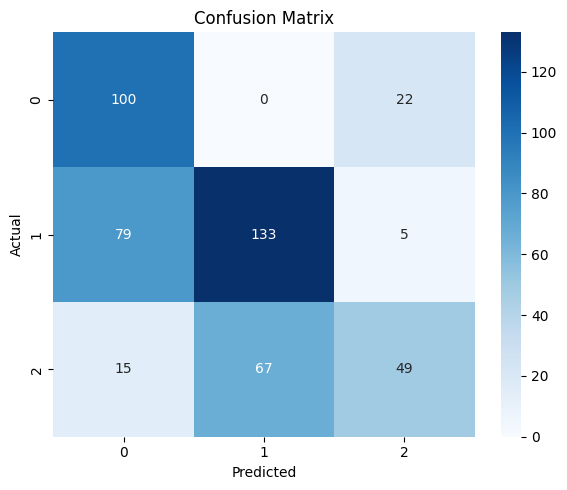

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_str, yticklabels=labels_str)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Saving ABSA Test Predictions to CSV for Evaluation and Visualization


In [ ]:
result_df = pd.DataFrame({
    'Input_Text': X_test,
    'True_Label': label_encoder.inverse_transform(y_test),
    'Predicted_Label': label_encoder.inverse_transform(y_test_pred)
})

absa_test_df = test_absa.reset_index(drop=True)
if 'aspect' in absa_test_df.columns and 'review' in absa_test_df.columns:
    result_df['Aspect'] = absa_test_df['aspect']
    result_df['Review'] = absa_test_df['review']
else:
    result_df['Review'] = result_df['Input_Text']

result_df.to_csv('predicted_reviews_transformers.csv', index=False)


[0 2 1]


/tmp/ipython-input-44-1349733448.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=result_df, x='Predicted_Label', order=['Negative', 'Neutral', 'Positive'], palette='pastel')


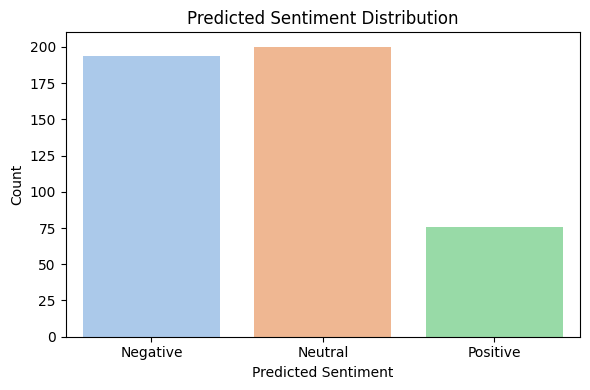

In [ ]:
if result_df['Predicted_Label'].dtype != 'O':
    label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    result_df['Predicted_Label'] = result_df['Predicted_Label'].map(label_map)

plt.figure(figsize=(6, 4))
sns.countplot(data=result_df, x='Predicted_Label', order=['Negative', 'Neutral', 'Positive'], palette='pastel')
plt.title('Predicted Sentiment Distribution')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


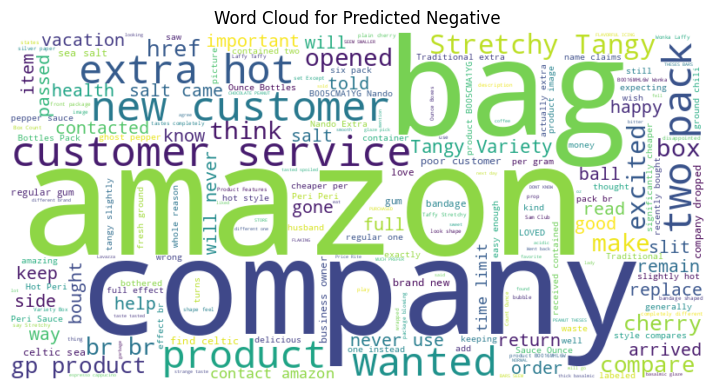

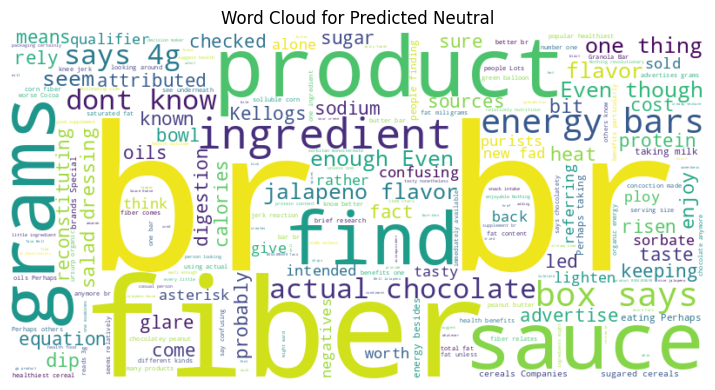

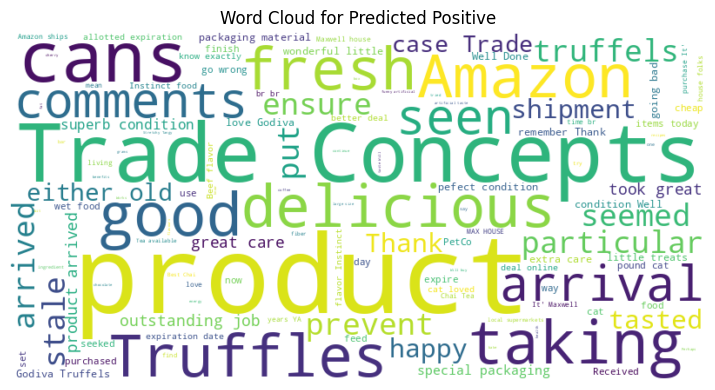

In [ ]:
for sentiment in ['Negative', 'Neutral', 'Positive']:
    sentiment_df = result_df[result_df['Predicted_Label'] == sentiment]

    text = ' '.join(sentiment_df['Review'])
    if text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Predicted {sentiment}')
        plt.tight_layout()
        plt.show()


# Future Work

For transformer-based models for BERT with ABSA, future directions include scaling up the training dataset significantly. The current model was limited by a small training subset (100 samples), which is insufficient for effective fine-tuning. Expanding the aspect-sentiment dataset via manual labeling, semi-supervised learning, or weak supervision would allow BERT to learn deeper contextual patterns. Alternatively, using lighter transformer variants like DistilBERT, ALBERT, or TinyBERT can reduce memory usage and allow broader experimentation under constrained environments. Additionally, applying data augmentation techniques such as back-translation, synonym replacement, or text generation using LLMs may help overcome data scarcity and improve model generalization. Lastly, integrating explainability tools like LIME or SHAP could increase the transparency of transformer predictions and support aspect-based sentiment reasoning in real-world applications.